In [624]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Rescaling
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


**Data Preparation**

In [625]:
dataset_temp, dataset_info = tfds.load("mnist", split=["train+test"], shuffle_files=True, as_supervised=True, with_info=True)

In [626]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/cheesemac/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [627]:
len(dataset_temp[0])

70000

In [628]:
dataset = dataset_temp[0]
VAL_TEST_RATIO = 0.1
TRAIN_RATIO = 1 - VAL_TEST_RATIO*2
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_TEST_RATIO))

test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_TEST_RATIO)))

print(len(test_dataset))
print(len(val_dataset))
print(len(train_dataset))

7000
7000
56000


In [629]:
list(test_dataset.take(1))

[(<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
  array([[[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0]],
  
         [[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
        

**Data Visualization**

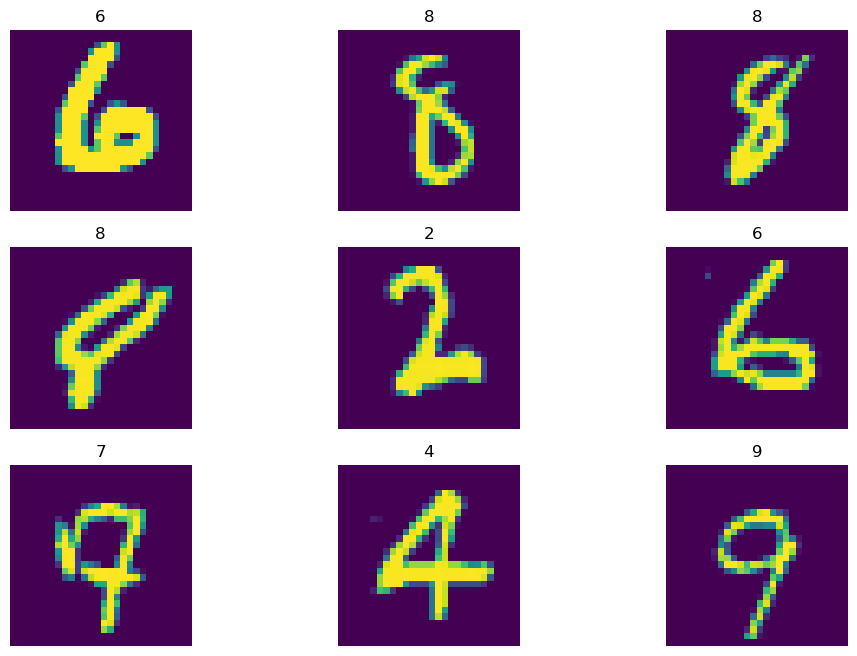

In [630]:
plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label.numpy())
    plt.axis("off")

plt.show();

**Data Processing**

In [631]:
# def normalize_image(img, label):
#     return img/255, label

normalization_layer = Rescaling(1./255)

In [632]:
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), tf.one_hot(y, 10)))

# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

This is to check if my data is normalized or not

In [633]:
for (img, label) in train_dataset.take(1):
    a = np.isclose(np.amax(img), 1)

print(a)

True


In [634]:
BUFFER_SIZE = 300
BATCH_SIZE = 250
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Modelling**

In [635]:
IMG_SIZE = 28

Here we will use sigmoid activation, since the images are black and white

In [636]:
relu_model = Sequential([
    # InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 1)),
    Conv2D(filters=64, kernel_size=3, activation = "relu", input_shape = (IMG_SIZE, IMG_SIZE, 1)),

    Conv2D(filters=32, kernel_size=3, padding="same", activation = "relu"),
    # BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, padding="valid", activation = "relu"),
    # BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),


    Flatten(),

    Dense(120, activation = "relu"),
    # BatchNormalization(),

    Dense(84, activation = "relu"),
    # BatchNormalization(),

    Dense(10, activation = "softmax")
])

relu_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 26, 26, 64)        640       
                                                                 
 conv2d_102 (Conv2D)         (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 11, 11, 16)        4624      
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_34 (Flatten)        (None, 400)             

In [637]:
relu_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss = CategoricalCrossentropy(),
                             metrics = "accuracy")

In [638]:
process = relu_model.fit(train_dataset,validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


2024-01-31 17:43:22.058305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


223/224 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8869

2024-01-31 17:43:27.048438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


224/224 [==============================] - 6s 25ms/step - loss: 0.3674 - accuracy: 0.8873 - val_loss: 0.1492 - val_accuracy: 0.9577
Epoch 2/5
224/224 [==============================] - 6s 25ms/step - loss: 0.5988 - accuracy: 0.8291 - val_loss: 0.2283 - val_accuracy: 0.9303
Epoch 3/5
224/224 [==============================] - 6s 26ms/step - loss: 0.1628 - accuracy: 0.9515 - val_loss: 0.1588 - val_accuracy: 0.9521
Epoch 4/5
224/224 [==============================] - 6s 25ms/step - loss: 0.1305 - accuracy: 0.9606 - val_loss: 0.1427 - val_accuracy: 0.9586
Epoch 5/5
224/224 [==============================] - 6s 25ms/step - loss: 0.1206 - accuracy: 0.9630 - val_loss: 0.1384 - val_accuracy: 0.9579


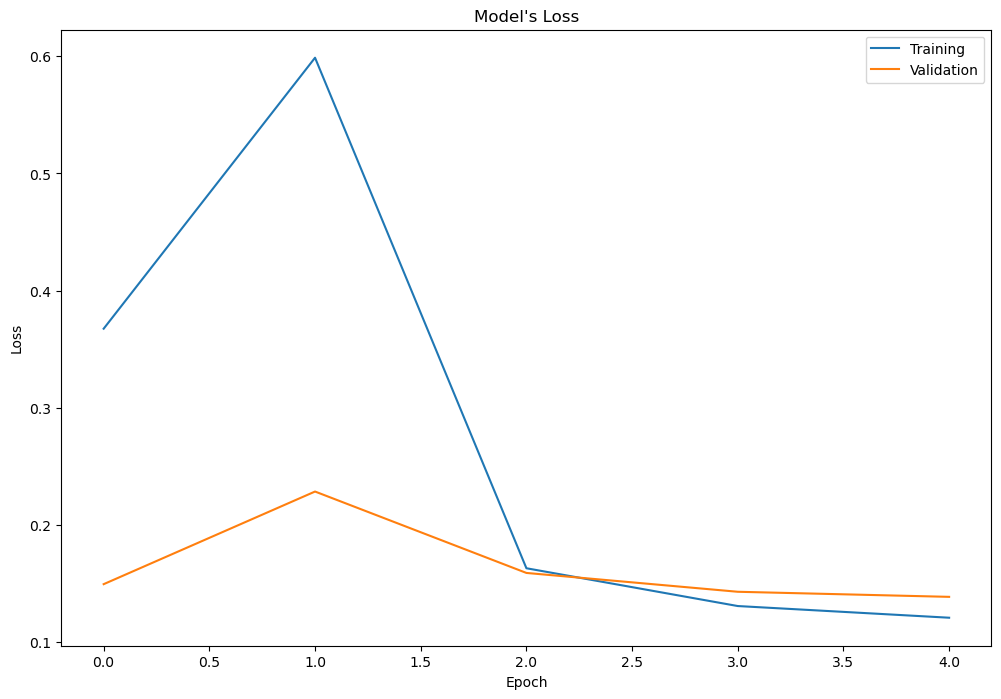

In [639]:
plt.figure(figsize=(12,8))
plt.plot(process.history["loss"])
plt.plot(process.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Model's Loss")

plt.show();

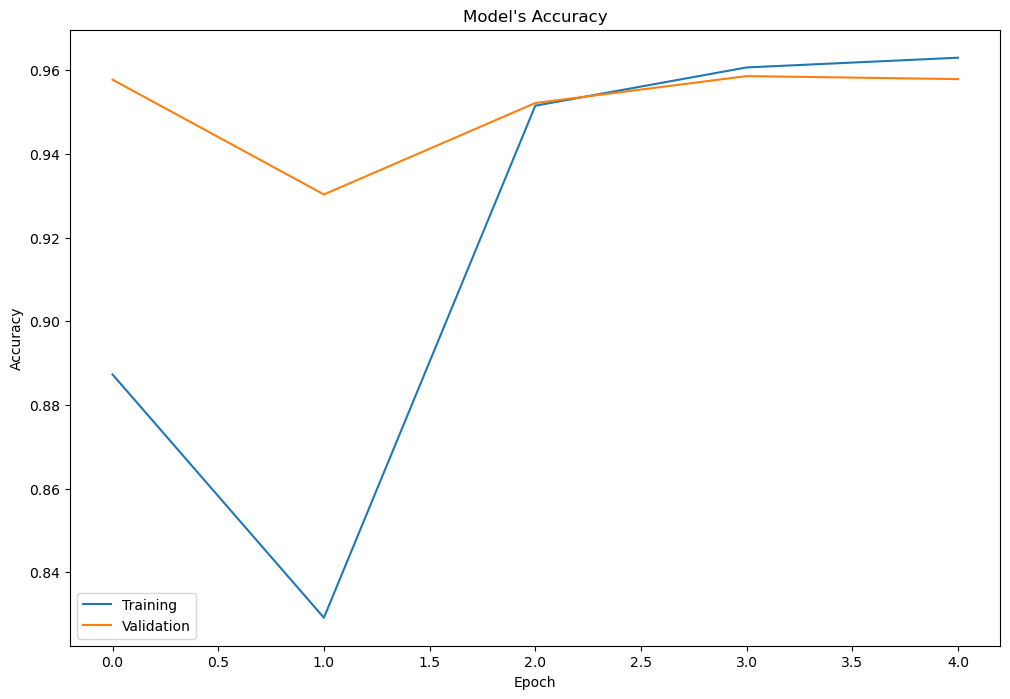

In [640]:
plt.figure(figsize=(12,8))
plt.plot(process.history["accuracy"])
plt.plot(process.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.title("Model's Accuracy")

plt.show();

**2 key improvements about this model:**  
1) Reducing the learning rate: the initial learning rate was way too high
2) Use `one_hot` to encode labels to shape `(None, 10)`, so that the output layer can have 10 neurons instead of just 1, and the output values are going to lie in `[0, 1]`, which allows us to use `"softmax"` activation